<a href="https://colab.research.google.com/github/ederquesado/kmeans/blob/master/KmeansWithNaiveBayesKC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_validate, KFold,StratifiedKFold , cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [2]:
def normalizeData(dataset):    
    max = list(dataset[0])
    min = list(dataset[0])

    for x in range(len(dataset)):
        for y in range(len(dataset[x])-1):
            if isinstance(dataset[x][y],float) == True:
                if dataset[x][y] > max[y]:
                    max[y] = dataset[x][y]
                if dataset[x][y] < min[y]:
                    min[y] = dataset[x][y]

    for x in range(len(dataset)):
        for y in range(len(dataset[x])-1):
            if isinstance(dataset[x][y],float) == True:
                dataset[x][y] = (dataset[x][y] - min[y])/ (max[y]-min[y])

In [3]:
data = loadarff('/content/kc1.arff')
raw_data = pd.DataFrame(data[0]).values
normalizeData(raw_data)
dataset = np.asarray(raw_data)

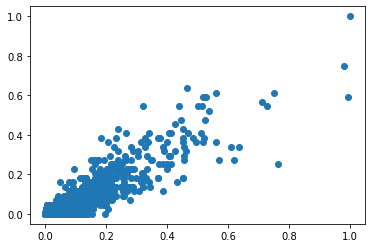

In [4]:
plt.scatter(dataset[:,0], dataset[:,1])

In [5]:
datasetKMeans = dataset[:,0:-1]

In [6]:
from sklearn.metrics import silhouette_score

In [7]:
sil = []
kmax = 6

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(datasetKMeans)
  labels = kmeans.labels_
  sil.append(silhouette_score(datasetKMeans, labels, metric = 'euclidean'))

In [8]:
k=[2,3,4,5,6]
sil.index(max(sil))
k[sil.index(max(sil))]

2

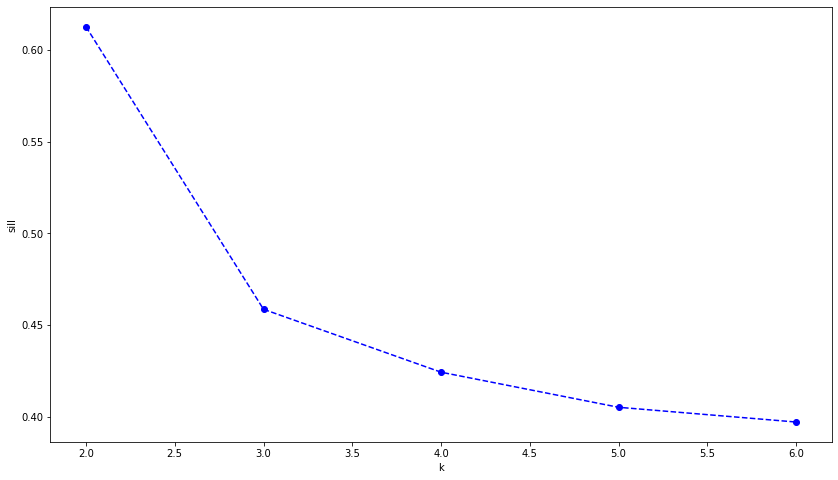

In [9]:
plt.figure(figsize=(14,8))
plt.plot(range(2,kmax+1),sil,color='blue',linestyle='dashed',marker='o')
plt.xlabel('k')
plt.ylabel('sill')
plt.show()

In [10]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [11]:
elbow = []
elbow =calculate_WSS(datasetKMeans,6)

In [12]:
elbow

[15.767326546472406,
 10.4952958742523,
 8.193308979929531,
 6.659129084559726,
 5.528317166675366]

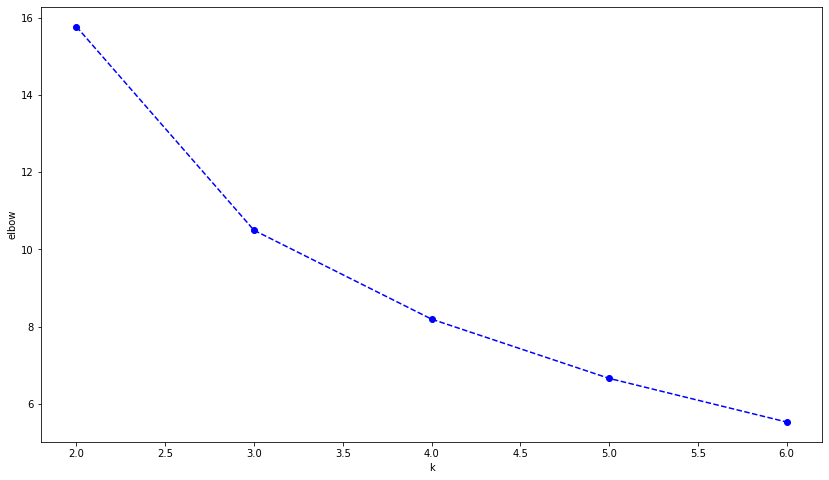

In [13]:
plt.figure(figsize=(14,8))
plt.plot(range(2,7),elbow,color='blue',linestyle='dashed',marker='o')
plt.xlabel('k')
plt.ylabel('elbow')
plt.show()

In [14]:
kmeans = KMeans(n_clusters = k[sil.index(max(sil))]).fit(datasetKMeans)

In [15]:
k[sil.index(max(sil))]

2

In [16]:
kmeans.labels_

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [17]:
dataset2 =np.concatenate([datasetKMeans, kmeans.labels_[:,None]], axis=1)

In [18]:
dataframe = pd.DataFrame(dataset2)   

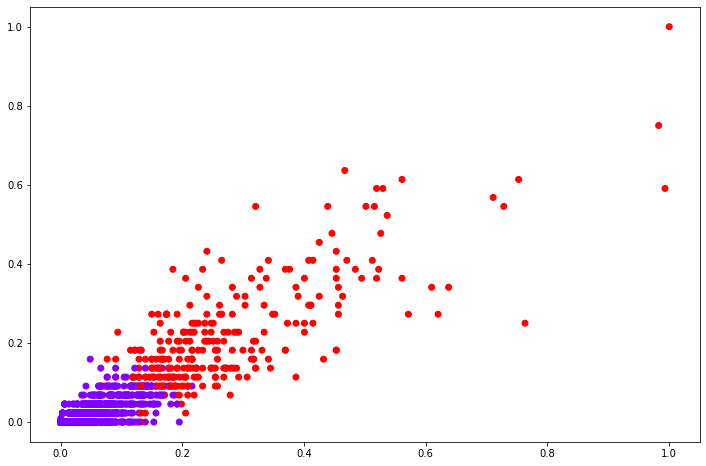

In [19]:

plt.figure(figsize=[12,8])
plt.scatter(dataset2[:,0], dataset2[:,1], c=dataset2[:,-1], cmap='rainbow')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(datasetKMeans, kmeans.labels_, test_size=0.33, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [21]:
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 696 points : 42


In [22]:
print(confusion_matrix(y_test, y_pred))

[[558  42]
 [  0  96]]


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       600
           1       0.70      1.00      0.82        96

    accuracy                           0.94       696
   macro avg       0.85      0.97      0.89       696
weighted avg       0.96      0.94      0.94       696



In [24]:
#--------------------------------------------------------------------------------------------------------------------
#--------- Avaliação Naive Bayes Com Agrupamento
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
cros_val = cross_validate(gnb, datasetKMeans, kmeans.labels_, cv=kf)
cross_val_predicted = cross_val_predict(gnb, datasetKMeans, kmeans.labels_, cv=kf)
cross_score_accuracy = cross_val_score(gnb, datasetKMeans,kmeans.labels_, cv=kf, scoring=make_scorer(accuracy_score))



print("Accuracy of Model with Cross Validation is:", cross_score_accuracy.mean() * 100)


Accuracy of Model with Cross Validation is: 94.49988715865493


In [25]:
conf_mat = confusion_matrix(kmeans.labels_, cross_val_predicted)
conf_mat

array([[1692,  119],
       [   0,  298]])

In [26]:
#--------------------------------------------------------------------------------------------------------------------
#--------- Avaliação 1-nn
XKNN = dataset[:,0:-1]
YKKN = dataset[:,-1].astype(str)

n_splits = 10

kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
knn_cros_val = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn_cros_val.fit(X_train,y_train)
#knn_cros_val.fit(XKNN, YKKN)
cros_val = cross_validate(knn_cros_val, XKNN, YKKN, cv=kf)

cross_val_predicted = cross_val_predict(knn_cros_val, XKNN, YKKN, cv=kf)
conf_mat = confusion_matrix(YKKN, cross_val_predicted)
conf_mat

cross_score_accuracy = cross_val_score(knn_cros_val, XKNN, YKKN, cv=kf, scoring=make_scorer(accuracy_score))



print("Accuracy of Model with Cross Validation is:", cross_score_accuracy.mean() * 100)


Accuracy of Model with Cross Validation is: 83.1665538253216


In [27]:
#--------------------------------------------------------------------------------------------------------------------
#--------- Avaliação Naive Bayes Sem Agrupamento
XKNN = dataset[:,0:-1]
YKKN = dataset[:,-1].astype(str)

n_splits = 10

kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
gnb = GaussianNB()
gnb.fit(X_train,y_train)
cros_val = cross_validate(gnb, XKNN, YKKN, cv=kf)

cross_val_predicted = cross_val_predict(gnb, XKNN, YKKN, cv=kf)
conf_mat = confusion_matrix(YKKN, cross_val_predicted)
conf_mat

cross_score_accuracy = cross_val_score(gnb, XKNN, YKKN, cv=kf, scoring=make_scorer(accuracy_score))



print("Accuracy of Model with Cross Validation is:", cross_score_accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 82.40916271721959
